<a href="https://colab.research.google.com/github/ktugceerdemli/WebScraping/blob/main/WSBooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Price Analysis with Web Scraping

**Bussiness Problem**

A company selling books online finds that it is under-selling in the ‘Travel’ and ‘Nonfiction’ categories. For this reason, the company needs to obtain information on the competitor's website https://books.toscrape.com/, which is permitted to be scraped, for books in the ‘Travel’ and ‘Nonfiction’ categories and to carry out a competitor and price analysis. The company expects you to go to the detail pages of each book in these categories and retrieve some of the information available there.

In [ ]:
!pip install selenium
!pip install bs4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.7/475.7 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.5 MB/s eta 0:00:00


Import all necessary libraries

In [3]:

from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.common.keys import Keys

Functions

In [10]:

def scrape_opt():
    # Chrome options for Selenium
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-blink-features=AutomationControlled')
    # Driver generation
    driver = webdriver.Chrome(options=chrome_options)
    return driver


def soup_html_data(driver, book_data):
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    book_elements = soup.select("ol.row li")

    if not book_elements:
        return False

    for book_element in book_elements:
        book_name = book_element.select_one("h3 a").get("title")
        book_price = float(book_element.select_one("p.price_color").text.replace('£', '').strip())
        book_availability = book_element.select_one("p.instock").text.strip()
        book_star = book_element.select_one("p.star-rating").get("class")[-1]

        book_info = {
            'name': book_name,
            'price': book_price,
            'availability': book_availability,
            'star': book_star
        }
        book_data.append(book_info)

    return True



Scrapping

In [11]:

driver = scrape_opt()
main_url = 'https://books.toscrape.com/'
driver.get(main_url)
time.sleep(3)

# Get category links
cat_elements = driver.find_elements(By.XPATH, "//a[contains(text(),'Travel') or contains(text(), 'Nonfiction')]")
cat_urls = [element.get_attribute("href") for element in cat_elements]

book_data = []

for cat in cat_urls:
    driver.get(cat)
    time.sleep(3)

    if 'travel' in cat.lower():
        page_url = cat
        driver.get(page_url)
        time.sleep(3)
        soup_html_data(driver, book_data)
    else:
        page_number = 1
        while True:
            page_url = f"{cat.replace('index.html', '')}page-{page_number}.html"
            driver.get(page_url)
            time.sleep(3)

            if not soup_html_data(driver, book_data):
                break

            page_number += 1

driver.quit()


Save the data

In [12]:

# Create a DataFrame from the collected book data
book_data_df = pd.DataFrame(book_data)

# Display the DataFrame
print(book_data_df)

book_data_df.to_csv("/content/book_df.csv", index=False)


                                                  name  price availability  \
0                              It's Only the Himalayas  45.17     In stock   
1    Full Moon over Noah’s Ark: An Odyssey to Mount...  49.43     In stock   
2    See America: A Celebration of Our National Par...  48.87     In stock   
3    Vagabonding: An Uncommon Guide to the Art of L...  36.94     In stock   
4                                 Under the Tuscan Sun  37.33     In stock   
..                                                 ...    ...          ...   
116                                      H is for Hawk  57.42     In stock   
117         Travels with Charley: In Search of America  57.82     In stock   
118                                          The Tumor  41.56     In stock   
119     The End of the Jesus Era (An Investigation #1)  14.40     In stock   
120                                    Eat, Pray, Love  51.32     In stock   

      star  
0      Two  
1     Four  
2    Three  
3      Two 

Analyze the data

In [35]:
book_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   name            121 non-null    object  
 1   price           121 non-null    float64 
 2   availability    121 non-null    object  
 3   star            121 non-null    object  
 4   price_category  121 non-null    category
 5   star_int        121 non-null    int64   
dtypes: category(1), float64(1), int64(1), object(3)
memory usage: 5.1+ KB


In [37]:
# Group by star rating and summarize
groupbystar = book_data_df.groupby('star').agg({
    'name': 'count',  # Count number of books per star rating
    'price': 'mean',  # Average price per star rating
}).rename(columns={'name': 'count', 'price': 'average_price'})

print(groupbystar)

       count  average_price
star                       
Five      21      36.537143
Four      20      37.705500
One       26      35.057308
Three     28      33.362143
Two       26      32.282308


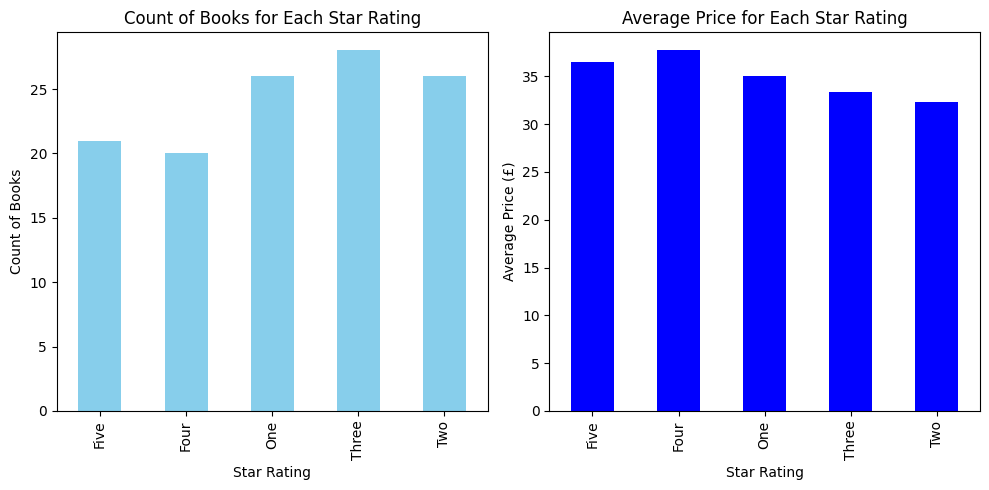

In [38]:
import matplotlib.pyplot as plt
# Plotting the count of books per star rating
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
groupbystar['count'].plot(kind='bar', color='skyblue')
plt.title('Count of Books for Each Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Count of Books')

# Plotting the average price per star rating
plt.subplot(1, 2, 2)
groupbystar['average_price'].plot(kind='bar', color='blue')
plt.title('Average Price for Each Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Average Price (£)')

plt.tight_layout()
plt.show()

In [24]:
book_data_df['price_category'] = pd.qcut(book_data_df['price'], q=3, labels=['Cheap', 'Average', 'Expensive'])

In [32]:
# Convert star ratings from text to numbers
book_data_df['star_int'] = book_data_df['star'].map({
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5
})

book_data_df['star_int'].astype(int)

0      2
1      4
2      3
3      2
4      3
      ..
116    5
117    5
118    5
119    1
120    3
Name: star_int, Length: 121, dtype: int64

In [34]:
# Group by star rating and summarize
groupbyprice = book_data_df.groupby('price_category').agg({
    'star_int': 'median',
    'name': 'count',  # Count number of books per star rating
    'price': 'mean',  # Average price per star rating
}).rename(columns={'name': 'count', 'price': 'average_price'})
print(groupbyprice)


                star_int  count  average_price
price_category                                
Cheap                3.0     41       19.57439
Average              3.0     40       34.40750
Expensive            3.0     40       50.68775


In [19]:
book_data_df["availability"].value_counts()

availability
In stock    121
Name: count, dtype: int64